In [ ]:
import datetime
import backtrader as bt

#Instantiate Cerebro engine
cerebro = bt.Cerebro(stdstats=False)

#Set data parameters and add to Cerebro
data1 = bt.feeds.YahooFinanceCSVData(
   dataname='TSLA.csv',
   fromdate=datetime.datetime(2018, 1, 1),
   todate=datetime.datetime(2020, 1, 1))
cerebro.adddata(data1)

data2 = bt.feeds.YahooFinanceCSVData(
   dataname='AAPL.csv',
   fromdate=datetime.datetime(2018, 1, 1),
   todate=datetime.datetime(2020, 1, 1))

data2.compensate(data1)  # let the system know ops on data1 affect data0
data2.plotinfo.plotmaster = data1
data2.plotinfo.sameaxis = True
cerebro.adddata(data2)

#Run Cerebro Engine
cerebro.run()
cerebro.plot()

In [3]:
import backtrader as bt

class PrintClose(bt.Strategy):
     
    def __init__(self):
         #Keep a reference to the "close" line in the data[0] dataseries
         self.dataclose = self.datas[0].close
    
    def log(self, txt, dt=None):     
        dt = dt or self.datas[0].datetime.date(0)     
        print('%s, %s' % (dt.isoformat(), txt)) #Print date and close

    def next(self):     
        #Log closing price to 2 decimals     
        self.log('Close: %.2f' % self.dataclose[0])

# Instantiate Cerebro engine
cerebro = bt.Cerebro()

# Add data feed to Cerebro
 
data = bt.feeds.YahooFinanceCSVData(dataname='TSLA.csv')
cerebro.adddata(data)

# Add strategy to Cerebro
cerebro.addstrategy(PrintClose)

# Run Cerebro Engine
cerebro.run()

2018-01-02, Close: 320.53
2018-01-03, Close: 317.25
2018-01-04, Close: 314.62
2018-01-05, Close: 316.58
2018-01-08, Close: 336.41
2018-01-09, Close: 333.69
2018-01-10, Close: 334.80
2018-01-11, Close: 337.95
2018-01-12, Close: 336.22
2018-01-16, Close: 340.06
2018-01-17, Close: 347.16
2018-01-18, Close: 344.57
2018-01-19, Close: 350.02
2018-01-22, Close: 351.56
2018-01-23, Close: 352.79
2018-01-24, Close: 345.89
2018-01-25, Close: 337.64
2018-01-26, Close: 342.85
2018-01-29, Close: 349.53
2018-01-30, Close: 345.82
2018-01-31, Close: 354.31
2018-02-01, Close: 349.25
2018-02-02, Close: 343.75
2018-02-05, Close: 333.13
2018-02-06, Close: 333.97
2018-02-07, Close: 345.00
2018-02-08, Close: 315.23
2018-02-09, Close: 310.42
2018-02-12, Close: 315.73
2018-02-13, Close: 323.66
2018-02-14, Close: 322.31
2018-02-15, Close: 334.07
2018-02-16, Close: 335.49
2018-02-20, Close: 334.77
2018-02-21, Close: 333.30
2018-02-22, Close: 346.17
2018-02-23, Close: 352.05
2018-02-26, Close: 357.42
2018-02-27, 

In [4]:
from datetime import datetime
import backtrader as bt


class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=20)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SmaCross)
    cerebro.broker.setcash(1337.0)
    cerebro.broker.setcommission(commission=0.001)
    
    data = bt.feeds.YahooFinanceCSVData(dataname='AAPL.csv',
                                        fromdate=datetime(2018, 1, 1),
                                        todate=datetime(2020, 1, 1))
    
    cerebro.adddata(data)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()

Starting Portfolio Value: 1337.00
Ending Portfolio Value: 1455.42


Starting Portfolio Value: 1337.00
Ending Portfolio Value: 1368.66


<IPython.core.display.Javascript object>


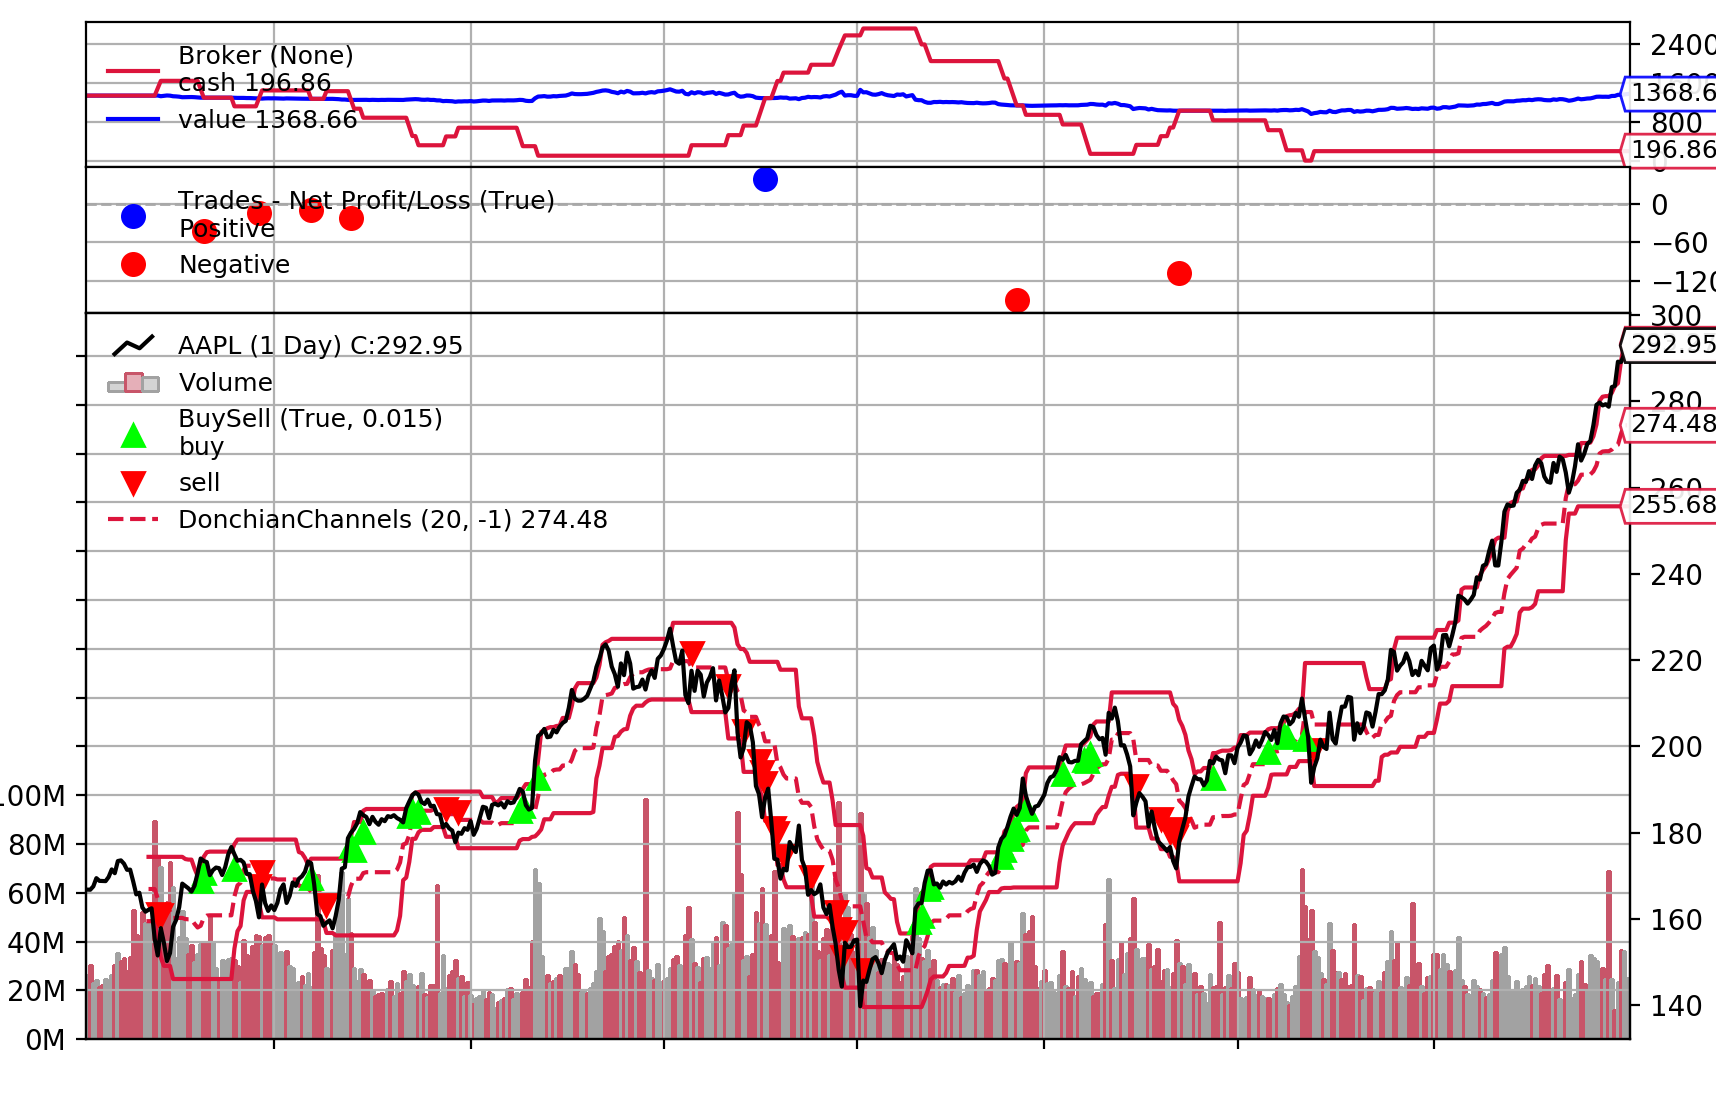

In [1]:
from datetime import datetime
import backtrader as bt


class DonchianChannels(bt.Indicator):
    '''
    Params Note:
      - `lookback` (default: -1)
        If `-1`, the bars to consider will start 1 bar in the past and the
        current high/low may break through the channel.
        If `0`, the current prices will be considered for the Donchian
        Channel. This means that the price will **NEVER** break through the
        upper/lower channel bands.
    '''

    alias = ('DCH', 'DonchianChannel',)

    lines = ('dcm', 'dch', 'dcl',)  # dc middle, dc high, dc low
    params = dict(
        period=20,
        lookback=-1,  # consider current bar or not
    )

    plotinfo = dict(subplot=False)  # plot along with data
    plotlines = dict(
        dcm=dict(ls='--'),  # dashed line
        dch=dict(_samecolor=True),  # use same color as prev line (dcm)
        dcl=dict(_samecolor=True),  # use same color as prev line (dch)
    )

    def __init__(self):
        hi, lo = self.data.high, self.data.low
        if self.p.lookback:  # move backwards as needed
            hi, lo = hi(self.p.lookback), lo(self.p.lookback)

        self.l.dch = bt.ind.Highest(hi, period=self.p.period)
        self.l.dcl = bt.ind.Lowest(lo, period=self.p.period)
        self.l.dcm = (self.l.dch + self.l.dcl) / 2.0  # avg of the above


class MyStrategy(bt.Strategy):
    def __init__(self):
        self.myind = DonchianChannels()

    def next(self):
        if self.data[0] > self.myind.dch[0]:
            self.buy()
        elif self.data[0] < self.myind.dcl[0]:
            self.sell()

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MyStrategy)
    cerebro.broker.setcash(1337.0)
    cerebro.broker.setcommission(commission=0.001)

    data = bt.feeds.YahooFinanceCSVData(dataname='AAPL.csv',
                                        fromdate=datetime(2017, 1, 1),
                                        todate=datetime(2020, 1, 1))
    
    cerebro.adddata(data)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()